# Loading

In [1]:
import matplotlib.pyplot as plt
import math
import matplotlib.font_manager as fm
import matplotlib as mpl


[f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name]
 # ['NanumBarunGothic',
 # 'NanumMyeongjo',
 # 'NanumMyeongjo',
 # 'NanumGothic',
 # 'NanumBarunGothic',
 # 'NanumGothic']

# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

In [11]:
import os
import pandas as pd
import torch
import torch.nn.functional as F

device = 'cuda:0'
path = '../../output/train/model/피부염/220228'
# path = '../../output/train/model/A2_비듬_각질_상피성잔고리/220228'

best_models = [f for f in os.listdir(path) if 'best' in f]
best_models.sort()
best_models
# checkpoints = [f for f in os.listdir(path) if 'checkpoint' in f]
# checkpoints

['C_FCE_100_2e-05_30_0.1_Adam_0.5_0.999_0.0001_pretrained_1.0-1.0-1.0_best-loss.pth.tar']

In [13]:
def argmax(x):
    f = lambda i: x[i]
    return max(range(len(x)), key=f)

def argmin(x):
    f = lambda i: x[i]
    return min(range(len(x)), key=f)

In [15]:
model_name = best_models[1]
for model_name in best_models:
    best = torch.load(os.path.join(path, model_name))
    check = torch.load(os.path.join(path, model_name.replace('best-loss','checkpoint')))
    # check = torch.load(os.path.join(path, model_name.replace('best','checkpoint')))

    print(model_name)
    print('epoch:', len(check['history']['valid_loss']))
    print('\ntrain_loss:', min(check['history']['train_loss']))
    print('valid_loss:', min(check['history']['valid_loss']))
    print('loss-best epoch:', argmin(check['history']['valid_loss'])+1)

# print('\nf1_0.0:', float(max(check['history']['f1_0.0'])))
# print('f1_0.0 best epoch:', argmax(check['history']['f1_0.0'])+1)

# print('\nf1_0.25:', float(max(check['history']['f1_0.25'])))
# print('f1_0.25:', argmax(check['history']['f1_0.25'])+1)

# print('\nf1_0.5:', float(max(check['history']['f1_0.5'])))
# print('f1_0.5:', argmax(check['history']['f1_0.5'])+1)

C_FCE_10_2e-05_30_0.1_Adam_0.5_0.999_0.0001_pretrained_0.1-1.45-1.45_best-loss.pth.tar
epoch: 10

train_loss: 0.019707003123436453
valid_loss: 0.018679908804352195
loss-best epoch: 10
C_FCE_10_2e-05_30_0.1_Adam_0.5_0.999_0.0001_pretrained_1.0-1.0-1.0_best-loss.pth.tar
epoch: 4

train_loss: 0.03040659105033556
valid_loss: 0.02957762904907249
loss-best epoch: 4


# Quantitative

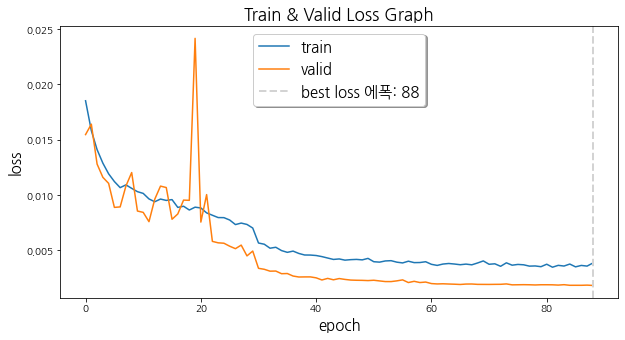

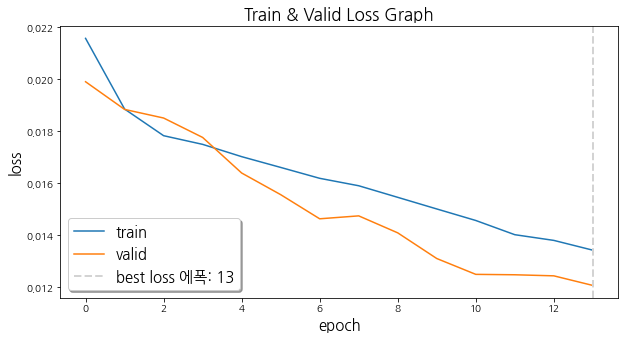

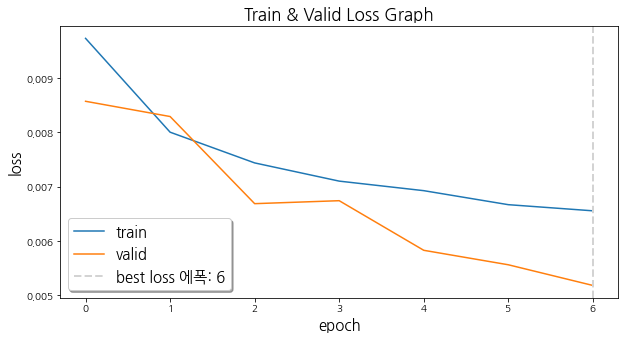

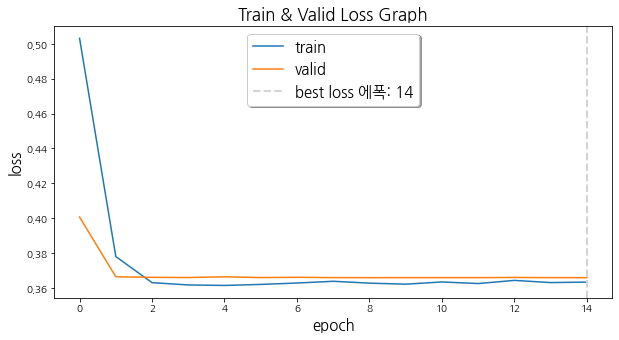

In [3]:
for best_model in best_models:
    model_name = best_model
    best_model_path = os.path.join(path, model_name)
    checkpoint_path = os.path.join(path, model_name.replace("loss_best", "checkpoint"))
    best_state = torch.load(best_model_path, map_location=device)
    checkpoint_state = torch.load(checkpoint_path, map_location=device)

    train_loss = checkpoint_state['history']['train_loss']
    valid_loss = checkpoint_state['history']['valid_loss']
    best_epoch = best_state["epoch"]

    def eval_graph(train_loss, valid_loss, best_epoch, model_name):
        fig = plt.figure(figsize=(10,5))
        plt.title('Train & Valid Loss Graph', size=17)
        plt.plot(train_loss, label='train')
        plt.plot(valid_loss, label='valid')
        plt.axvline(best_epoch, color='lightgray', linestyle='--', linewidth=2,
                   label=f'best loss 에폭: {best_epoch}')
        plt.xlabel('epoch', size=15)
        plt.ylabel('loss', size=15)
        plt.legend(loc='best', fontsize=15, frameon=True, shadow=True)
    eval_graph(train_loss, valid_loss, best_epoch, model_name)

In [ ]:
def eval_graph(best_models):
    fig = plt.figure(figsize=(20,12*len(best_models)))
    for i, model_name in enumerate(best_models):
        # model info
        best_model_path = os.path.join(path, model_name)
        checkpoint_path = os.path.join(path, model_name.replace("best-loss", "checkpoint"))
        best_state = torch.load(best_model_path, map_location=device)
        checkpoint_state = torch.load(checkpoint_path, map_location=device)
        # loss plot
        ax = fig.add_subplot(len(best_models), 1, i+1)
        ax.set_title(f'{model_name}\nbest model 에폭: {best_state["epoch"]}', size=30)
        ax.plot(checkpoint_state['history']['train_loss'], label='train')
        ax.plot(checkpoint_state['history']['valid_loss'], label='valid')
#         ax.plot(checkpoint_state['history']['train_loss'], label='train')
        ax.tick_params(axis = 'x', labelsize =20)
        ax.tick_params(axis = 'y', labelsize =20)
        ax.legend(loc='best', fontsize=50, frameon=True, shadow=True)
        ax.axvline(best_state["epoch"], color='lightgray', linestyle='--', linewidth=2)

eval_graph(best_models)

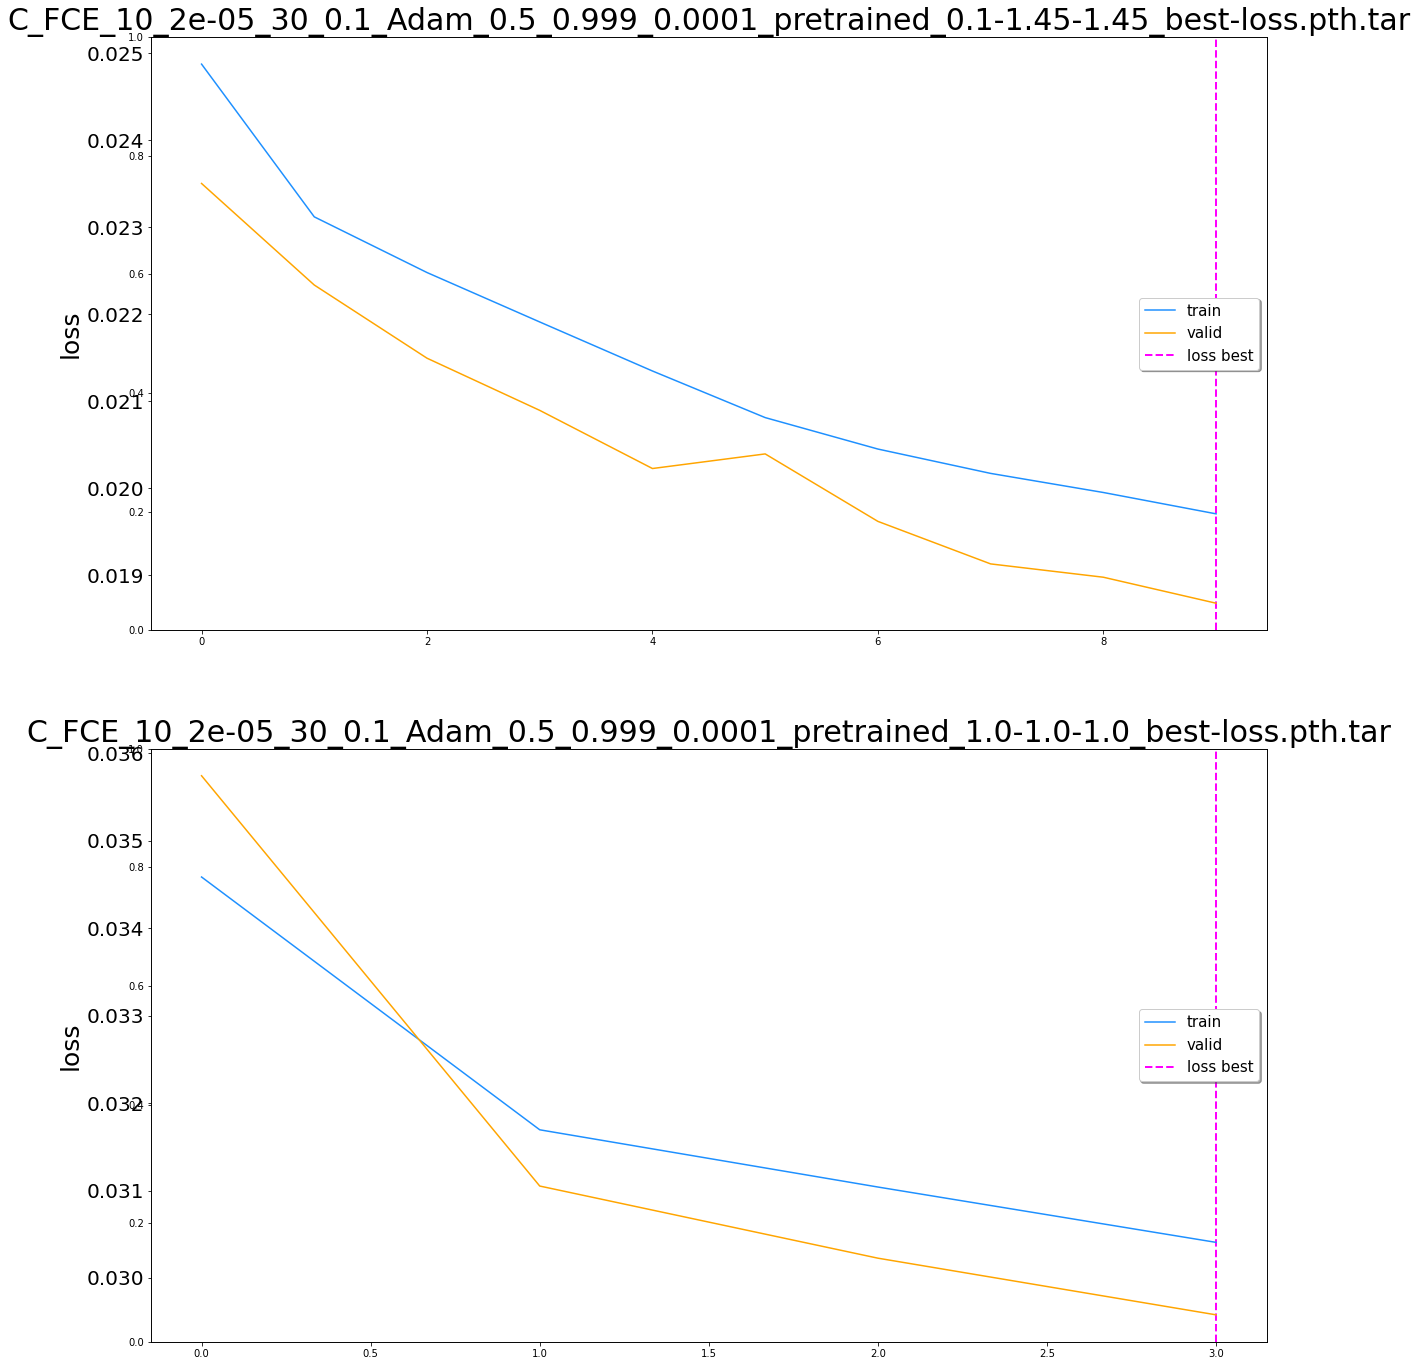

In [16]:
def eval_graph(best_models):
    fig = plt.figure(figsize=(20,12*len(best_models)))
    for i, model_name in enumerate(best_models):
        # model info
        best_model_path = os.path.join(path, model_name)
        checkpoint_path = os.path.join(path, model_name.replace("best-loss", "checkpoint"))
        best_state = torch.load(best_model_path, map_location=device)
        checkpoint_state = torch.load(checkpoint_path, map_location=device)
        
        ax1 = fig.add_subplot(len(best_models), 1, i+1)
        ax1.set_title(f'{model_name}', size=30)
        ax2 = ax1.twinx()
        
        # f1-score plot
        if 'f1_0.0' in checkpoint_state['history']:
            step = 0.25
            width = 0.8 - 0.2 * 2
            alpha = 1
            bar1 = ax1.bar(x=[x-step for x in range(len(checkpoint_state['history']['f1_0.0']))],
                           height=[float(x) for x in checkpoint_state['history']['f1_0.0']], width = width,
                           alpha=alpha, label='f1_0', color='powderblue')
            bar2 = ax1.bar(x=list(range(len(checkpoint_state['history']['f1_0.25']))),
                           height=[float(x) for x in checkpoint_state['history']['f1_0.25']],width = width,
                           alpha=alpha, label='f1_25', color='palegoldenrod')
            bar3 = ax1.bar(x=[x+step for x in range(len(checkpoint_state['history']['f1_0.5']))],width = width,
                           height=[float(x) for x in checkpoint_state['history']['f1_0.5']],
                           alpha=alpha, label='f1_50', color='thistle')

            ax1.tick_params(axis = 'x', labelsize =20)
            ax1.tick_params(axis = 'y', labelsize =20, which='both')
            ax1.yaxis.set_label_position('right')
            ax1.yaxis.set_ticks_position('right')
            ax1.set_ylabel('f1-score', fontsize=25)
            
            line4 = ax1.axhline(0.7, color='black', linestyle='-', linewidth=1)
            line5 = ax1.axvline(argmax(checkpoint_state['history']['f1_0.0']), color='blue', linestyle='-.', linewidth=2, label='f1_0 best')
            line6 = ax1.axvline(argmax(checkpoint_state['history']['f1_0.25']), color='orange', linestyle='--', linewidth=2, label='f1_25 best')
            line7 = ax1.axvline(argmax(checkpoint_state['history']['f1_0.5']), color='green', linestyle=':', linewidth=2, label='f1_50 best')
        
        # loss plot
        line1 = ax2.plot(checkpoint_state['history']['train_loss'], label='train', color='dodgerblue')
        line2 = ax2.plot(checkpoint_state['history']['valid_loss'], label='valid', color='orange')
        ax2.tick_params(axis = 'y', labelsize =20)
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.set_ticks_position('left')
        ax2.set_ylabel('loss', fontsize=25)
        line3 = ax1.axvline(argmin(checkpoint_state['history']['valid_loss']), color='fuchsia', linestyle='--', linewidth=2, label='loss best')
        
        
        # legend
        plots = line1+line2+[line3]
        if 'f1_0.0' in checkpoint_state['history']:
            plots += [bar1, bar2, bar3]
            plots += [line4, line5, line6, line7]
        labels = [p.get_label() for p in plots]
        ax2.legend(plots, labels, loc='center right', fontsize=15, frameon=True, shadow=True)

eval_graph(best_models)

In [31]:
bar1 = ax1.bar(x=list(range(len(checkpoint_state['history']['f1_0.0']))),
                       height=[float(x) for x in checkpoint_state['history']['f1_0.0']],
                       alpha=0.3, label='f1_0')

NameError: name 'ax1' is not defined

In [128]:
model_path = os.path.join(path, 'Ab01-xception-FCE-100-0.0002-pretrained-0.01-0.2-0.79_loss_best.pth.tar')

In [3]:
def eval_table(best_models):
    for i, model_name in enumerate(best_models):
        # model info
        best_model_path = os.path.join(path, model_name)
        best_state = torch.load(best_model_path, map_location=device)

        result = {}
        for mt, v in best_state['history'].items():
            for task, val in v.items(): 
                try:
                    result[mt+'_'+task] = [val['train'][-1], val['valid'][-1]]
                except:
                    continue
        result = pd.DataFrame(result, index=['train', 'valid'])
        
        print(model_name)
        display(result)
        print()
eval_table(best_models)

AttributeError: 'list' object has no attribute 'items'

# Qualititative

In [16]:
import torch.nn.functional as F
from utils import *
from evaluation import *

def one_hot_encoding(x, num_classes, dim=1):
    """ 
        x : torch.Tensor
            values with (0 ~ num_classes-1)
    """
    assert isinstance(num_classes, int), "num_classes should be an 'int' type"
    x_size = list(x.size())
    x_encoded_size = x_size[:dim] + [num_classes] + x_size[dim:]
    x_encoded = torch.zeros(x_encoded_size, dtype=torch.long)
    slicing_list = [':']*dim + ["i"] # + [':']*(len(x_encoded_size)-dim-1)
    slicing = "[" + ",".join(slicing_list) + "]"
    for i in range(num_classes):
        exec(f"x_encoded{slicing}[x==i] = 1")
    return x_encoded
    
def _visualize(model, batches, args, model_name=None):
    code = args.root.split('/')[-2]
    disease = {"Ab01": "간비대", "Ch02": "기관허탈"}.get(code)
    
    img = batches[0].to(device)
    GT = batches[1].to(device)#.type(torch.float32)

    model.train(False)
    model.eval()

    with torch.no_grad():
        SR = model(img)
        SR_probs = F.softmax(SR, dim=1)
        SR = make_one_hot(torch.argmax(SR, dim=1, keepdim=True), num_classes=args.out_ch) # onehot
        GT = make_one_hot(GT.unsqueeze(1), num_classes=3)
        
        # evaluation
        ious = SegmentationEvaluation(num_classes=3).get_IoU(
            SR.contiguous().view(SR.shape[0], SR.shape[1], -1),
            GT.contiguous().view(GT.shape[0], GT.shape[1], -1))[:, 1:]
        
        # plot setup
        row = img.size(0)
        show_list = [img, 
                     SR, GT]
        col = len(show_list)
        fig = plt.figure(figsize=(6*col, 7*row))
#         fig.suptitle(f'{code}-{disease} segmentation' if model_name is None else \
#                      f'{code}-{disease} segmentation\n{model_name}', fontsize=30)
        fig.suptitle(f'{model_name}', fontsize=25)
        titles = ["origial", "predict", "ground truth"]
        
        # show images
        i = 0
        for r in range(row):
            for c in range(col):
                i+=1
                ax = fig.add_subplot(row, col, i)
                if (i%col) == 0:
                    ax.set_title(titles[(i-1)%col], size=20)
                elif (i%col) == col-1:
                    ax.set_title(titles[(i-1)%3], size=20)
                else:
                    ax.set_title(titles[(i-1)%col], size=20)
                ax.axis('off')
                #print(r, c, show_list[c][r].size())
                if c in [1,2]:
                    ax.imshow(np.transpose(show_list[c][r].cpu().detach().numpy(), (1,2,0)), cmap='gray')
                else:
                    ax.imshow(np.transpose(show_list[c][r].cpu().detach().numpy(), (1,2,0)))

In [15]:
from collections import OrderedDict
from network.deeplab import DeepLabv3plus
from network import build_model

def get_model(state):
    args=state['args']
    args.pretrained = False
    model = build_model(args)
    model = model.to(device)
    
    new_state_dict = OrderedDict()
    if args.distributed:
        for k, v in state['state_dict'].items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(state['state_dict'])
    return model

In [13]:
from dataloader import *
data_path = '../../../data/피부염'
# data_path = '../../../data/A2_비듬_각질_상피성잔고리'
dataset = PetSkinDataset(root=data_path, mode='test', valid_ratio=0.2, test_ratio=0.2, seed=42)
loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False,
                                            num_workers=4, pin_memory=True)

In [8]:
best_models

['C_FCE_100_2e-05_30_0.1_Adam_0.5_0.999_0.0001_pretrained_1.0-1.0-1.0_best-loss.pth.tar']

../../../data/피부염/C6_비감염성피부염/CYT_D_C6_002915.jpg
../../../data/피부염/C1_감염성피부염/CYT_D_C1_001998.jpg
../../../data/피부염/C6_비감염성피부염/CYT_D_C6_001138.jpg
../../../data/피부염/C6_비감염성피부염/CYT_D_C6_002264.jpg


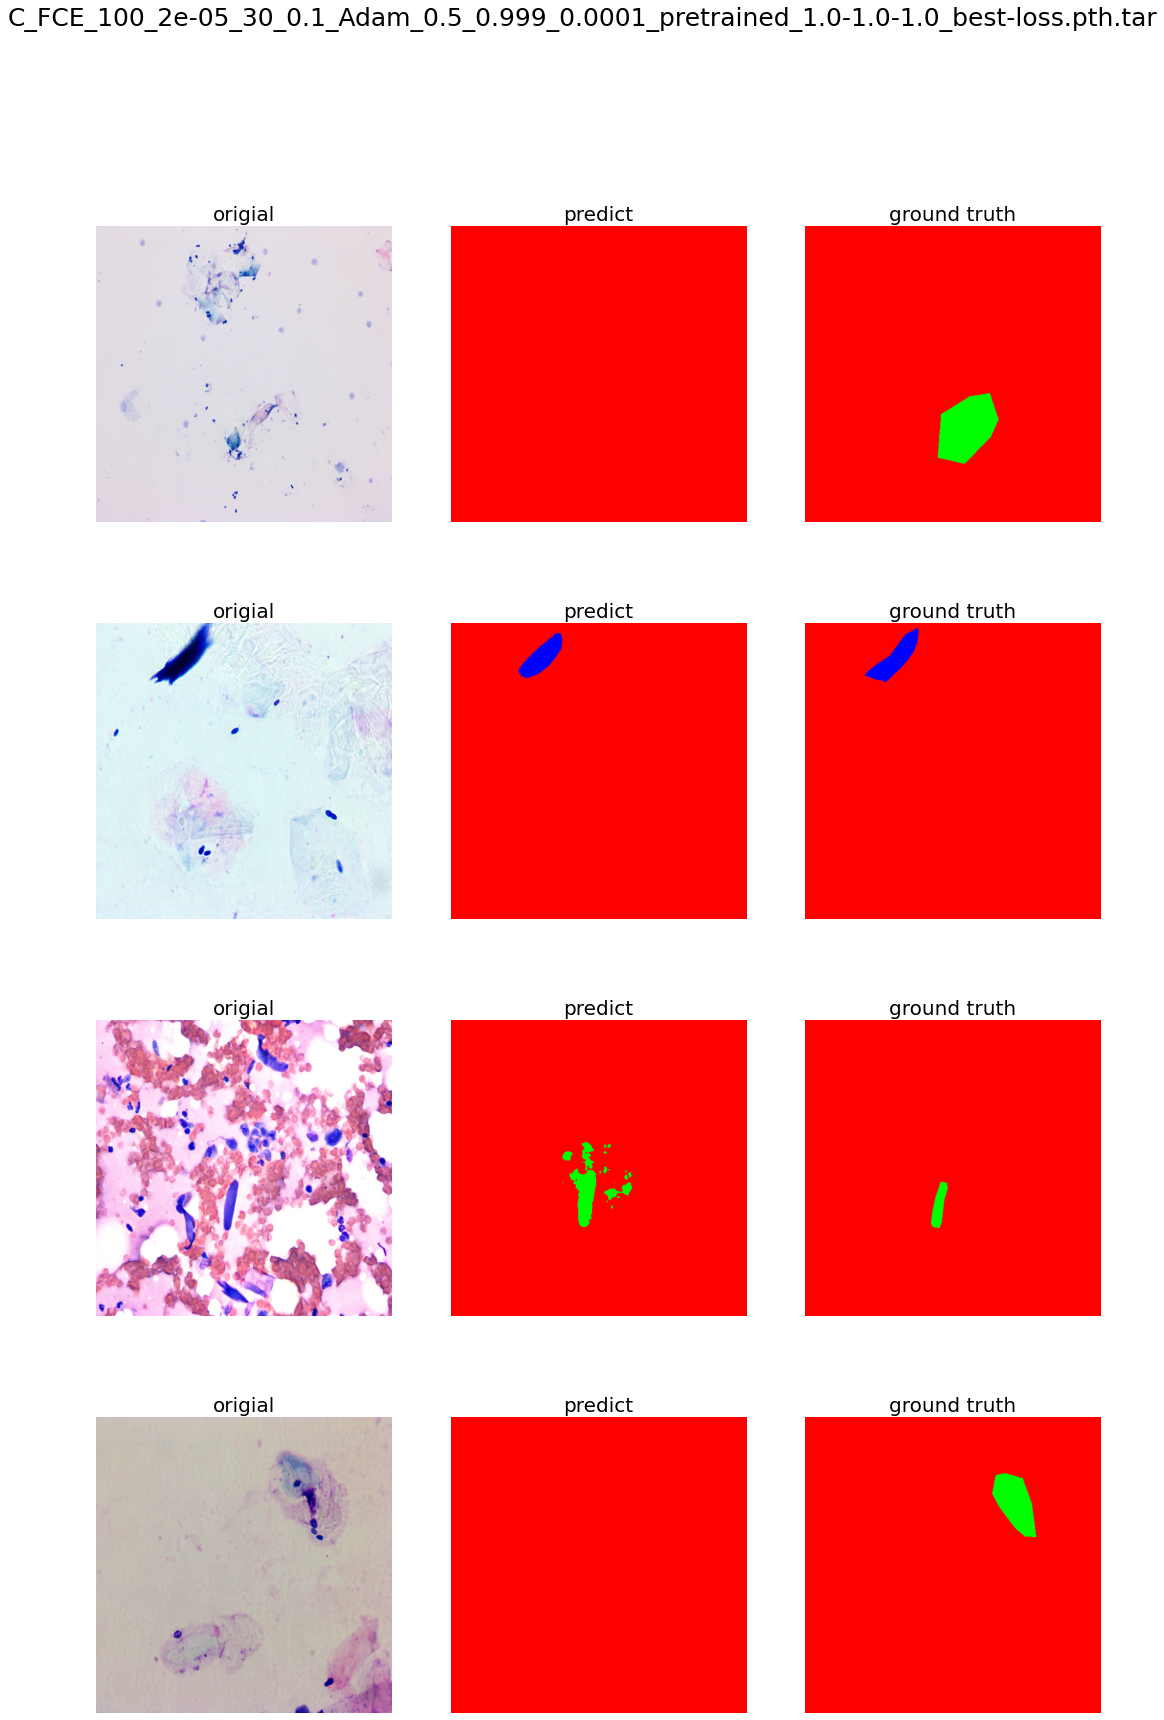

In [17]:
# 30 첫번째 질환을 정상으로 잡음
model_path = os.path.join(path, best_models[0])
# model_path = os.path.join(path, best_models[3].replace('best', 'checkpoint'))
def visualize(model_path, loader, index=0, batch_size=4):
    # model info
    best_state = torch.load(model_path, map_location=device)
    model = get_model(best_state)

    images, masks, labels = [], [], []
    for b_i in range(batch_size*index, batch_size*(index+1)):
        image = loader.dataset[b_i]['input']
        mask = loader.dataset[b_i]['mask']
        images.append(image.unsqueeze(0))
        masks.append(mask.unsqueeze(0))
        print(loader.dataset[b_i]['img_name'])
    batches = [torch.cat(v, dim=0) for v in (images, masks)]

    _visualize(model, batches, best_state['args'], model_path.split('/')[-1])
visualize(model_path, loader, index=2, batch_size=4) 

# 모델 비교에 사용되는 이미지
# Ab01: index=0, batch_size=4
# Ch02: index=9, batch_size=4

# Inference 결과 테스트

(1080, 1920)


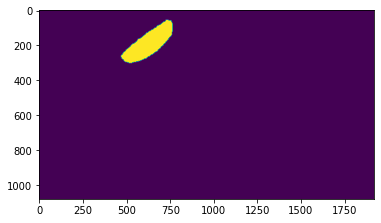

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

mask = np.zeros((1000,1000), dtype=np.uint64)
polygons = [[[726, 56], [726, 62], [725, 63], [722, 63], [722, 65], [721, 66], [714, 66], [714, 68], [713, 69], [710, 69], [710, 71], [709, 72], [706, 72], [706, 74], [705, 75], [702, 75], [702, 78], [701, 79], [698, 79], [698, 81], [697, 82], [694, 82], [694, 84], [693, 85], [686, 85], [686, 87], [685, 88], [678, 88], [678, 91], [677, 92], [674, 92], [674, 97], [673, 98], [670, 98], [670, 100], [669, 101], [662, 101], [662, 103], [661, 104], [658, 104], [658, 107], [657, 108], [654, 108], [654, 110], [653, 111], [646, 111], [646, 113], [645, 114], [642, 114], [642, 116], [641, 117], [638, 117], [638, 119], [637, 120], [630, 120], [630, 123], [629, 124], [626, 124], [626, 126], [625, 127], [622, 127], [622, 129], [621, 130], [614, 130], [614, 135], [613, 136], [610, 136], [610, 139], [609, 140], [606, 140], [606, 142], [605, 143], [602, 143], [602, 145], [601, 146], [598, 146], [598, 148], [597, 149], [594, 149], [594, 152], [593, 153], [590, 153], [590, 155], [589, 156], [586, 156], [586, 158], [585, 159], [582, 159], [582, 161], [581, 162], [574, 162], [574, 164], [573, 165], [566, 165], [566, 171], [565, 172], [562, 172], [562, 177], [561, 178], [558, 178], [558, 180], [557, 181], [554, 181], [554, 184], [553, 185], [550, 185], [550, 187], [549, 188], [546, 188], [546, 190], [545, 191], [538, 191], [538, 193], [537, 194], [534, 194], [534, 196], [533, 197], [530, 197], [530, 200], [529, 201], [526, 201], [526, 206], [525, 207], [522, 207], [522, 209], [521, 210], [518, 210], [518, 213], [517, 214], [514, 214], [514, 216], [513, 217], [510, 217], [510, 219], [509, 220], [506, 220], [506, 222], [505, 223], [502, 223], [502, 225], [501, 226], [498, 226], [498, 232], [497, 233], [494, 233], [494, 235], [493, 236], [490, 236], [490, 238], [489, 239], [486, 239], [486, 241], [485, 242], [482, 242], [482, 248], [481, 249], [478, 249], [478, 254], [477, 255], [474, 255], [474, 257], [473, 258], [470, 258], [470, 270], [473, 270], [474, 271], [474, 277], [477, 277], [478, 278], [478, 280], [481, 280], [482, 281], [482, 283], [485, 283], [486, 284], [486, 290], [489, 290], [490, 291], [490, 293], [493, 293], [494, 294], [494, 296], [505, 296], [506, 297], [506, 299], [513, 299], [514, 300], [514, 302], [533, 302], [533, 300], [534, 299], [541, 299], [541, 297], [542, 296], [557, 296], [557, 294], [558, 293], [569, 293], [569, 291], [570, 290], [581, 290], [581, 287], [582, 286], [589, 286], [589, 284], [590, 283], [597, 283], [597, 281], [598, 280], [601, 280], [601, 278], [602, 277], [613, 277], [613, 275], [614, 274], [617, 274], [617, 271], [618, 270], [621, 270], [621, 268], [622, 267], [625, 267], [625, 265], [626, 264], [633, 264], [633, 262], [634, 261], [637, 261], [637, 258], [638, 257], [641, 257], [641, 255], [642, 254], [649, 254], [649, 252], [650, 251], [653, 251], [653, 249], [654, 248], [657, 248], [657, 246], [658, 245], [661, 245], [661, 242], [662, 241], [665, 241], [665, 239], [666, 238], [673, 238], [673, 236], [674, 235], [677, 235], [677, 233], [678, 232], [681, 232], [681, 226], [682, 225], [685, 225], [685, 223], [686, 222], [689, 222], [689, 220], [690, 219], [693, 219], [693, 217], [694, 216], [697, 216], [697, 210], [698, 209], [701, 209], [701, 207], [702, 206], [705, 206], [705, 204], [706, 203], [709, 203], [709, 201], [710, 200], [713, 200], [713, 194], [714, 193], [717, 193], [717, 191], [718, 190], [721, 190], [721, 188], [722, 187], [725, 187], [725, 181], [726, 180], [729, 180], [729, 178], [730, 177], [733, 177], [733, 172], [734, 171], [737, 171], [737, 169], [738, 168], [741, 168], [741, 162], [742, 161], [745, 161], [745, 156], [746, 155], [749, 155], [749, 153], [750, 152], [753, 152], [753, 149], [754, 148], [757, 148], [757, 143], [758, 142], [761, 142], [761, 124], [762, 123], [765, 123], [765, 75], [762, 75], [761, 74], [761, 66], [758, 66], [757, 65], [757, 59], [742, 59], [741, 58], [741, 56]]]
# polygon = [np.array(poly, dtype=np.int8) for poly in polygon]
# cv2.fillPoly(mask, polygon, 1)
# mask = np.stack([np.zeros((1000,1000), dtype=np.uint64), np.zeros((1000,1000), dtype=np.uint64), mask])


mask = Image.new('L', (1920, 1080), 0)

for poly in polygons:
#     poly = [tuple(xy) for xy in poly]
    poly = list(map(tuple, poly))
    ImageDraw.Draw(mask).polygon(poly, outline=1, fill=1)
mask = np.array(mask).astype('int64')
print(mask.shape)

plt.imshow(mask)

In [38]:
torch.cuda.device_count()

2

In [ ]:
from TTA.deeplab.dataloader import PetSegDataset
dataset=PetSegDataset('./data/sample/Ab01', 'test')
    
model_path = os.path.join(path, './')
# model_path = os.path.join(path, best_models[3].replace('best', 'checkpoint'))
def visualize(model_path, loader, index=0, batch_size=4):
    # model info
    best_state = torch.load(model_path, map_location=device)
    model = get_model(best_state)

    images, masks, labels = [], [], []
    for b_i in range(batch_size*index, batch_size*(index+1)):
        image = loader.dataset[b_i]['input']
        mask = loader.dataset[b_i]['mask']
        images.append(image.unsqueeze(0))
        masks.append(mask.unsqueeze(0))
        print(loader.dataset[b_i]['img_name'])
    batches = [torch.cat(v, dim=0) for v in (images, masks)]

    _visualize(model, batches, best_state['args'], model_path.split('/')[-1])
visualize(model_path, loader, index=1, batch_size=4) 
    

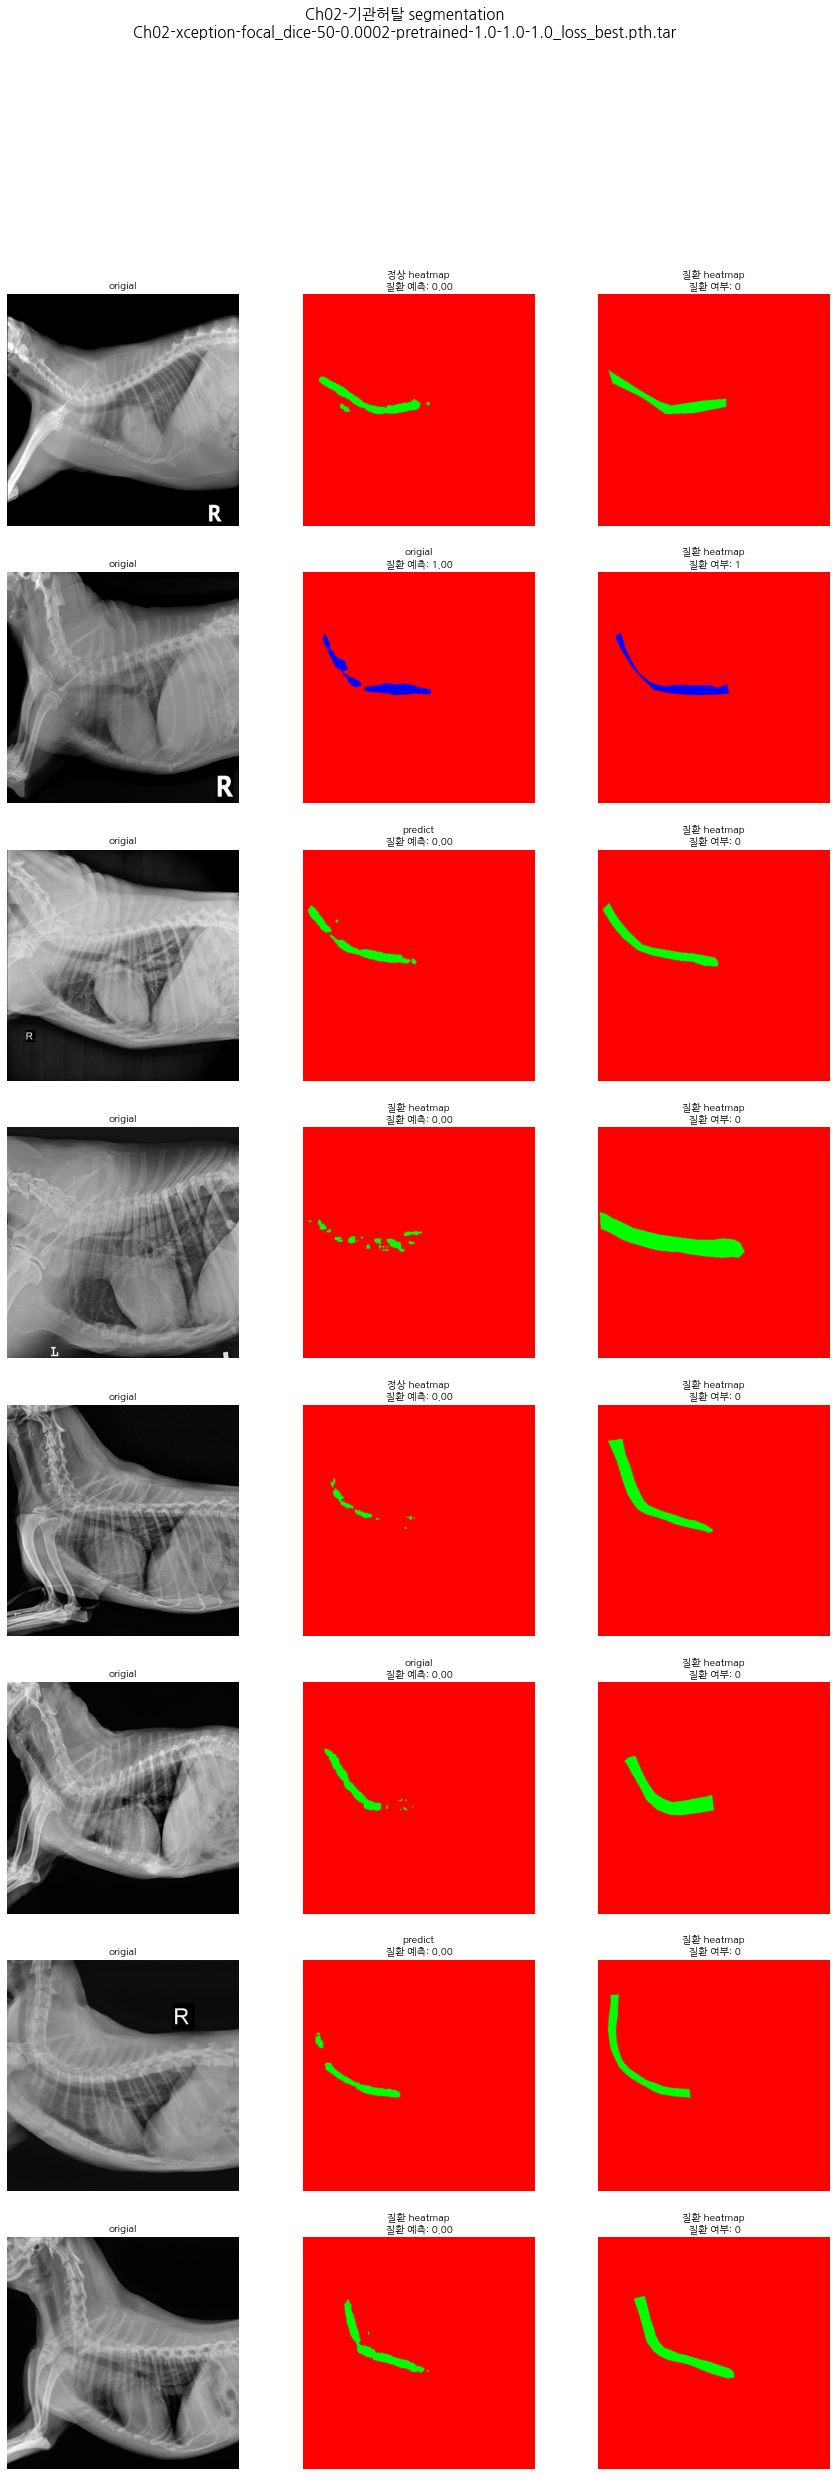

In [19]:
import torch.nn.functional as F

# 30 첫번째 질환을 정상으로 잡음
path = './TTA/models/2021-12-09'
def visualize(best_models, loader, index=0, batch_size=4):
    for i, model_name in enumerate(best_models):
        # model info
        best_model_path = os.path.join(path, model_name)
        best_state = torch.load(best_model_path, map_location=device)
        model = get_model(best_state)
        
        images, masks, labels = [], [], []
        for b_i in range(batch_size*index, batch_size*(index+1)):
            image, mask, label = loader.dataset[b_i]
            images.append(image.unsqueeze(0))
            masks.append(mask.unsqueeze(0))
            labels.append(label.unsqueeze(0))
        batches = [torch.cat(v, dim=0) for v in (images, masks, labels)]
        
        _visualize(model, batches, best_state['args'], model_name)

visualize([best_models[-1]], loader, index=29, batch_size=8)

# Confusion Matrix

In [30]:
imgs, masks, labels, sizes = next(iter(loader['valid']))
sr, cr = model(img.to(device))

In [40]:
torch.argmax(sr[0],dim=0)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [43]:
torch.argmax(cr, dim=1).size()

torch.Size([4, 1, 1])

In [55]:
torch.any(torch.argmax(sr, dim=1)[0] == 1)

tensor(False, device='cuda:0')

In [66]:
len(loader['valid'])

114

In [72]:
SR = {"1": [], "2": []}
CR = np.zeros((2,2), dtype=np.int64)

for i, batches in enumerate(loader['valid']):
    img, mask, label, sizes = batches
    sr, cr = model(img.to(device))
    cr = torch.argmax(cr, dim=1)
    for n in range(label.size(0)):
        pred = int(cr[n, 0, 0])
        CR[pred, label[[n, 0, 0]]] += 1
        if torch.any(torch.argmax(sr, dim=1)[n, 1] == 1):
            SR["1"].append(sr)
        elif torch.any(torch.argmax(sr, dim=1)[n, 2] == 1):
            SR["2"].append(sr)            

In [89]:
import pandas as pd
pd.DataFrame(CR.tolist(), columns = ['gt_false', 'gt_true'], index = ["pred_false", "pred_true"])

,gt_false,gt_true
pred_false,408,52
pred_true,0,0


# Metric

In [154]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, jaccard_score
y_true = np.array(['cat', 'dog', 'pig', 'cat', 'dog', 'pig'])
y_pred = np.array(['cat', 'pig', 'dog', 'cat', 'cat', 'dog'])

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))

(0.2222222222222222, 0.3333333333333333, 0.26666666666666666, None)
(0.3333333333333333, 0.3333333333333333, 0.3333333333333333, None)
(0.2222222222222222, 0.3333333333333333, 0.26666666666666666, None)


In [166]:
y_true = torch.Tensor([1,2,3,2,1,3,1,2,3,4,1,2,3])
y_pred = torch.Tensor([1,1,3,2,1,3,2,3,4,4,1,3,3])

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(jaccard_score(y_true, y_pred, average='macro'))
print(jaccard_score(y_true, y_pred, average='micro'))
print(jaccard_score(y_true, y_pred, average='weighted'))


(0.5875, 0.6875, 0.6041666666666666, None)
(0.6153846153846154, 0.6153846153846154, 0.6153846153846154, None)
(0.6076923076923078, 0.6153846153846154, 0.5897435897435896, None)
0.45
0.4444444444444444
0.43846153846153846
[0.6 0.2 0.5 0.5]


In [165]:
y_true = torch.randint(low=0, high=3, size=(4,3,10,10))
y_pred = torch.randint(low=0, high=3, size=(4,3,10,10))
y_true = y_true.view(-1)
y_pred = y_pred.view(-1)

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))
print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
print(jaccard_score(y_true, y_pred, average='macro'))
print(jaccard_score(y_true, y_pred, average='micro'))
print(jaccard_score(y_true, y_pred, average='weighted'))

(0.34349860143503186, 0.34379417334133117, 0.34362799377216263, None)
(0.3433333333333333, 0.3433333333333333, 0.3433333333333333, None)
(0.34328854963753525, 0.3433333333333333, 0.3432927283376606, None)
0.20758568790826856
0.20724346076458752
0.2073387108411302


In [171]:
y_true = torch.randint(low=0, high=2, size=(4,2))
y_pred = torch.randint(low=0, high=2, size=(4,2))

torch.argmax(y_true, dim=1)

tensor([0, 0, 0, 1])

# Backbone Test

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import vgg13_bn, vgg16_bn, resnet50, resnet101
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101

In [12]:
img, mask, _, _ = next(iter(loader['valid']))
img.size()

torch.Size([4, 3, 512, 512])

In [14]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=3, init_features=32, pretrained=False)
output = model(img)
type(output)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


torch.Tensor

In [16]:
output.size()

torch.Size([4, 3, 512, 512])

In [18]:
model = deeplabv3_resnet101(pretrained=False, num_classes= 3)
output = model(img)
type(output)

collections.OrderedDict

In [67]:
torch.max(output['out'])

tensor(1.7382, grad_fn=<MaxBackward1>)

In [26]:
from networks.xception import xception
xception = xception(pretrained = True)

In [27]:
xception

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): xcept_block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv

In [12]:
resnet50 = resnet50(pretrained=True)
resnet101 = resnet101(pretrained=True)

In [20]:
resnet50.layer1[0]

Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [25]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
deeplab50 = deeplabv3_resnet50()
deeplab101 = deeplabv3_resnet101()

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [9]:
deeplab101.modules()

NameError: name 'deeplab101' is not defined

In [253]:
efficientnet_b4 = models.efficientnet_b4(pretrained=True)
efficientnet_b7 = models.efficientnet_b7(pretrained=True)

AttributeError: module 'torchvision.models' has no attribute 'efficientnet_b4'

In [203]:
encoder = vgg13_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /root/.cache/torch/hub/checkpoints/vgg13_bn-abd245e5.pth


  0%|          | 0.00/508M [00:00<?, ?B/s]

In [210]:
vgg16 = vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [272]:
Conv1 = encoder.features[:6]
Conv2 = encoder.features[6:13]
Conv3 = encoder.features[13:20]
Conv4 = encoder.features[20:27]
Conv5 = encoder.features[27:34]
bottleneck = encoder.features[34:]
print(Conv1)
print(Conv2)
print(Conv3)
print(Conv4)
print(Conv5)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
)
Sequential(
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
)
Sequential(
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3),

In [3]:
from network.backbone import *
encoder = VGG_Encoder(img_ch=3, num_classes=2, classification=True, pretrained=True)

In [4]:
type(encoder.Down_conv1)

torch.nn.modules.container.Sequential

In [1]:
import torch
from networks.segmentation.unet import U_Net
model = U_Net(3,3, encoder = 'vgg', pretrained=False, classification=True, attention=True).to('cuda')
x = torch.rand((4, 3, 256, 256)).to('cuda')
y = model(x)

In [8]:
a = []
a.append(1,2)
a

TypeError: append() takes exactly one argument (2 given)

In [7]:
model.Classifier[-5:]
model.Up4

up_conv(
  (up): Sequential(
    (0): ConvTranspose2d(512, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
)

0 : VGG_Encoder
1 : 

In [32]:
for i, module in enumerate(model.modules()):
    if i == 6:
        print(module.__class__.__name__)
        break

Conv2d


In [9]:
print(y[0].size())
print(y[1].size())

torch.Size([4, 3, 256, 256])
torch.Size([4, 2, 1, 1])
